In [0]:
# Fine tunning，模型微调
# 利用已经训练好的模型，来对另外的数据集进行训练，提升小数据集上的精度
# 称之为迁移学习， 此时就会用到fine tunning

# 其思路如下：
# 在源数据上训练一个神经网络
# 去除头部（输入），将输出层修改为适合目标数据的大小
# 将输出层的权重初始化为随机值，但是其他层保持与原先训练好的权重一直
# 随后在目标数据集进行训练

import zipfile

from mxnet import gluon

data_dir = 'datasets'
fname = gluon.utils.download('https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/hotdog.zip',
                path=data_dir, sha1_hash='fba480ffa8aa7e0febbb511d181409f899b9baa5')

with zipfile.ZipFile(fname, 'r') as f:
  f.extractall(data_dir)

In [0]:
from mxnet import nd
from mxnet import image
from mxnet import gluon


train_augs = [image.HorizontalFlipAug(.05), image.RandomCropAug((224, 224))]
test_augs = [image.CenterCropAug((224, 224))]


def transform(data, label, augs):
  data = data.astype('float32')
  for aug in augs:
    data = aug(data)
  data = nd.transpose(data, (2, 0, 1))
  return data, nd.array([label]).asscalar().astype('float32')

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt


def show_images(imgs, nrows, ncols, figsize=None):
  if not figsize:
    figsize = (ncols, nrows)
  _, figs = plt.subplots(nrows, ncols, figsize=figsize)
  for i in range(nrows):
    for j in range(ncols):
      figs[i][j].imshow(imgs[i*ncols + j].asnumpy())
      figs[i][j].axes.get_xaxis().set_visible(False)
      figs[i][j].axes.get_yaxis().set_visible(False)
  plt.show()

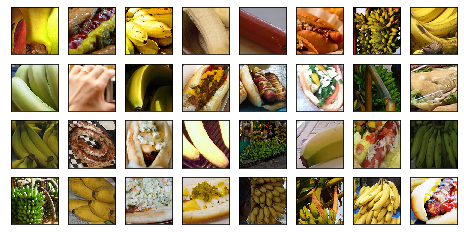

In [23]:
train_images = gluon.data.vision.ImageFolderDataset(
    data_dir+'/hotdog/train', transform=lambda x, y: transform(x, y, train_augs))
test_images = gluon.data.vision.ImageFolderDataset(
    data_dir+'/hotdog/test', transform=lambda x, y: transform(x, y, test_augs))

data = gluon.data.DataLoader(train_images, 32, shuffle=True)
for x, _ in data:
  x = x.transpose((0, 2, 3, 1)).clip(0, 255)/255
  show_images(x, 4, 8)
  break

In [24]:
# 使用gluon提供的ResNet18来进行训练。gluon的模型源当中已经
# 准备了预训练的模型，只需要进行下载，并加载从imagenet数据集上
# 训练得到的权重

from mxnet.gluon.model_zoo import vision as models

pretrained_net = models.resnet18_v2(pretrained=True)

In [34]:
# 预训练的模型包含2部分：特征数据集(features)和分类(output)。
# 后者主要包括最后一层全连接层，前者包括从输入开始的大部分层
# 通过features可以获得每一层的权重信息，output则只包括了最后
# 输出层的信息

pretrained_net.output
pretrained_net.features[1].params.get('weight').data()[0][0]


[[-1.64019989e-16 -1.64107318e-15  1.15900094e-14 -1.45087223e-14
   6.13736823e-15  9.31420553e-15 -4.96812310e-15]
 [-5.24587960e-15 -6.12600231e-15  2.52703958e-15 -1.26492343e-14
  -8.80555886e-15 -9.94531707e-15  3.19777765e-15]
 [ 6.95685058e-15  1.30257726e-14 -9.37785412e-15 -2.26256455e-15
  -1.28336622e-14 -1.03294219e-14  2.46130834e-15]
 [ 1.46163040e-14 -1.04503681e-14 -1.71437571e-14 -8.13254205e-15
  -4.71141028e-15  8.24006865e-15  3.25102235e-15]
 [ 1.74203032e-14 -1.88471827e-14 -2.52042954e-14 -3.48773736e-15
   2.85282793e-15  2.09951079e-16  6.23012214e-16]
 [-3.97822237e-15  2.91143075e-15  1.07994753e-15 -6.06272895e-15
  -8.24556759e-15  7.16038963e-15  2.21876333e-14]
 [-4.45479614e-15 -1.42962814e-15  4.07669588e-15 -9.37792633e-16
  -9.36154578e-16 -2.20163980e-15  1.13034124e-14]]
<NDArray 7x7 @cpu(0)>

In [0]:
# Fine tuning则需要创建新的模型，新的网络，除了最后的输出数等于
# 当前数据的类别数

from mxnet import init

finetune_net = models.resnet18_v2(classes=2)
finetune_net.features = pretrained_net.features # 从训练好的模型拷贝
finetune_net.output.initialize(init.Xavier()) # 随机初始化最后的输出层

In [0]:
def train(net, ctx, batch_size=64, epochs=10, learning_rate=0.01, wd=0.001):
  train_data = gluon.data.DataLoader(train_images, batch_size, shuffle=True)
  test_data = gluon.data.DataLoader(test_images, batch_size)

  net.collect_params().reset_ctx(ctx)
  net.hybridize()
  loss = gluon.loss.SoftmaxCrossEntropyLoss()
  trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate, 'wd': wd})
  import utils
  utils.train(train_data, test_data, net, loss, trainer, ctx, epochs)

In [38]:
# 可以看到，迁移学习的训练精度和测试精度都比较高
import mxnet
ctx = mxnet.gpu()
train(finetune_net, ctx)

Epoch 0. Loss: 0.354201, Train acc 0.850098, Test acc 0.915865
Epoch 1. Loss: 0.169162, Train acc 0.934082, Test acc 0.914663
Epoch 2. Loss: 0.116096, Train acc 0.958008, Test acc 0.943510
Epoch 3. Loss: 0.098393, Train acc 0.963867, Test acc 0.937500
Epoch 4. Loss: 0.074740, Train acc 0.977539, Test acc 0.945913
Epoch 5. Loss: 0.072573, Train acc 0.973633, Test acc 0.933894
Epoch 6. Loss: 0.061990, Train acc 0.982422, Test acc 0.951923
Epoch 7. Loss: 0.069679, Train acc 0.976562, Test acc 0.935096
Epoch 8. Loss: 0.037371, Train acc 0.990234, Test acc 0.945913
Epoch 9. Loss: 0.035077, Train acc 0.990723, Test acc 0.953125


In [39]:
# 对比从0开始的模型，其训练精度和测试精度都较低
scratch_net = models.resnet18_v2(classes=2)
scratch_net.initialize(init=init.Xavier())
train(scratch_net, ctx)

Epoch 0. Loss: 0.486149, Train acc 0.772949, Test acc 0.823317
Epoch 1. Loss: 0.368048, Train acc 0.843262, Test acc 0.816106
Epoch 2. Loss: 0.342752, Train acc 0.846680, Test acc 0.750000
Epoch 3. Loss: 0.330314, Train acc 0.854492, Test acc 0.828125
Epoch 4. Loss: 0.308391, Train acc 0.863281, Test acc 0.844952
Epoch 5. Loss: 0.305295, Train acc 0.864746, Test acc 0.824519
Epoch 6. Loss: 0.281384, Train acc 0.878906, Test acc 0.842548
Epoch 7. Loss: 0.266416, Train acc 0.887695, Test acc 0.849760
Epoch 8. Loss: 0.274536, Train acc 0.883789, Test acc 0.823317
Epoch 9. Loss: 0.267947, Train acc 0.888184, Test acc 0.831731


In [0]:
# 使用fine tuning的训练结果进行图片的预测

def classify_hotdog(net, fname):
  with open(fname, 'rb') as f:
    img = image.imdecode(f.read())
  data, _ = transform(img, -1, test_augs)
  plt.imshow(data.transpose((1, 2, 0)).asnumpy()/255)
  data = data.expand_dims(axis=0)
  out = net(data.as_in_context(ctx))
  out = nd.SoftmaxActivation(out)
  pred = int(nd.argmax(out, axis=1).asscalar())
  prob = out[0][pred].asscalar()
  label = train_images.synsets
  return 'With prob=%f, %s' % (prob, label[pred])

'With prob=0.975401, hotdog'

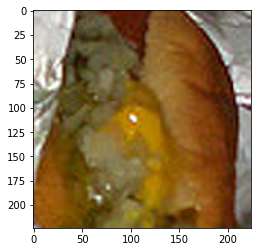

In [44]:
classify_hotdog(finetune_net, 'datasets/hotdog/test/hotdog/1000.png')

'With prob=0.998473, not-hotdog'

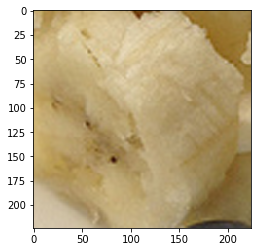

In [45]:
classify_hotdog(finetune_net, 'datasets/hotdog/test/not-hotdog/1000.png')